<a href="https://colab.research.google.com/github/JackSD/Data-Science-Work/blob/master/Network_Analysisv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Detecting Identity Fraud through Network Analysis and Personal Data re-use

The re-use of data points representing an individual is a key predictor in identity fraud and synthetic identity fraud with several of the cases studies featuring re-use of data.

This study looks at the possible of how to best detect this kind of re-use in the network of personal data, based on the assumption that generally, an edge between individuals and their personal data should appear on the system only once, given the near-uniqueness of the edges (eg [Name,DOB])

The network is set up with the nodes as data points, and the edges the connections between them, with a wighting according to how many times that edge appears in the data.

the goals are therefore to:
* detect suspicious clusters of data points
* scale with additional semi-personal data points (eg ipaddress, address data)
* support the addition of additional data points which point to suspicious activity such as the date of account set-up (many accounts set up on the same day or month for example)

In [ ]:
import networkx as nx
import pandas as pd
from matplotlib import pyplot as plt
import math
import numpy as np
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Functions needed for netwok analysis and drawing oof netowrks
# ------------------------------------------------
# get the key with the max value
def keywithmaxval(d ):
     v=list(d.values())
     k=list(d.keys())
     return k[v.index(max(v))]

# show a subnetwork, given a key
def show_subnet(G, key, withlabels=False, highlight_keys = None):
  G1 = get_subnet(G, key) 
  draw_network(G1,withlabels,highlight_keys)

def draw_network(G1,withlabels,highlight_keys, weights=True, display='fruchterman_reingold_layout'):
  plt.clf()
  if display=='fruchterman_reingold_layout':
    pos = nx.fruchterman_reingold_layout(G1)
  elif display=='Neato':
    pos = nx.nx_pydot.pydot_layout(G, prog="neato")
  else:
    pos = nx.spring_layout(G1)

  if weights:
    widths = list(nx.get_edge_attributes(G1, 'count').values())
    # widths for drawing do not show if weight =0
    widths = [x+1 for x in widths] 
  else:
    widths = 0.5
  nx.draw(G1, with_labels=withlabels,pos=pos, alpha=0.6, edge_color='b', node_color='red',font_color='black',
            node_size = 0.3, width=widths)
  if highlight_keys != None:
    draw_first_degree_connections(highlight_keys,withlabels, pos)
  plt.show()

def draw_first_degree_connections(highlight_keys,withlabels, pos= None): 
    edges_filtered_singlenetwork = edges[edges['value.x'].isin(highlight_keys) | edges['value.y'].isin(highlight_keys) ] 
    nx.draw_networkx(nx.from_pandas_edgelist(df=edges_filtered_singlenetwork,source= 'value.x',target="value.y", edge_attr =  ['count']), 
                     pos=pos,with_labels=withlabels, font_size=8,  node_size = 0.3, width=0.5, edge_color='red', 
                     node_color='red', font_color='red')

def get_subnet(G, key):
  k = nx.node_connected_component(G, key)
  edges_filtered_singlenetwork = edges[edges['value.x'].isin(list(k)) | edges['value.y'].isin(list(k)) ]  
  G1=nx.from_pandas_edgelist(df=edges_filtered_singlenetwork,source= 'value.x',target="value.y", edge_attr =  ['count'])
  return(G1)

def get_n_depth_neighbourhood(G,node,degree):
  nodes = get_neighborhood(G,node,degree)
  edges_filtered_singlenetwork = edges[edges['value.x'].isin(nodes) & edges['value.y'].isin(nodes) ]  
  G1=nx.from_pandas_edgelist(df=edges_filtered_singlenetwork,source= 'value.x',target="value.y", edge_attr =  ['count'])
  return(G1)

# n is the degree/hops (modified from: https://stackoverflow.com/questions/22742754/finding-the-n-degree-neighborhood-of-a-node)
def get_neighborhood(G, node, degree):
    path_lengths = nx.single_source_dijkstra_path_length(G, node)
    return [node for node, length in path_lengths.items()
                    if length <= degree]

def label_nodes(G,mapping_dict):
  # for metrics; label must be a number  
  n=0
  mapping = {}
  for x,y in mapping_dict.items():
    # mapping[x] = 'Node'+str(n)+':'+str(round(y,2))
    mapping[x] = x+':'+str(round(y,2))
    n=n+1
  G2 = nx.relabel_nodes(G,mapping)
  return(G2)

def print_scores(G,mapping_dict):
  # for metrics; label must be a number  
  n=0
  mapping = {}
  for x,y in mapping_dict.items():
    if x in G.nodes:
      mapping['Node'+str(n)] =round(y,2)
      n=n+1
  df = pd.DataFrame(mapping, index=['score'])
  df = df.T
  df.sort_values(by='score',inplace=True, ascending=False)
  return(df)

### Normal Expectations of a network of personal data

To illustrate what normal should look like, the network below represents a small network of data that you could assume to be normal, some of the semi-personal data is shared (such as a date of birth) while unique data is not shared (eg. tax numbers are 1:1 with an identity)

in a small network, this would be very sparse (as illustrated below) however in a larger dataset it would be denser as there are more collisions of semi-personal data


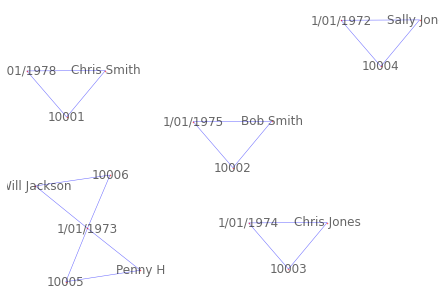

In [ ]:
# (this is synthetic data to illustrate expectations about a network of personal data)
df1 = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/basic_network.csv')
G=nx.from_pandas_edgelist(df=df1,source= 'value1',target="value2", edge_attr =  ['value1', 'value2'])
draw_network(G,withlabels=True,highlight_keys=None, weights=False, display='Neato')



In [ ]:
edges = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/xx_edge_pairs.csv')
edges = edges[edges['value.y'].notnull() & edges['value.x'].notnull() ]
G=nx.from_pandas_edgelist(df=edges,source= 'value.x',target="value.y", edge_attr =  ['count','count_minus_1'] )

In [ ]:
edges.shape

(1360572, 4)

### Understanding what normal looks like 

This shows a 1000 edge sample of the network, showing the sparse structure of the network 

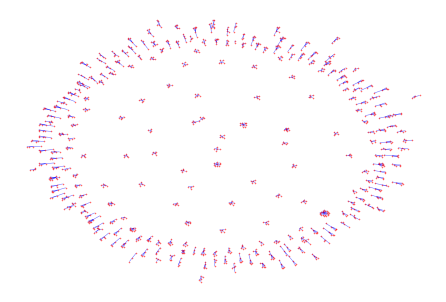

In [ ]:
edges_small = edges.head(1000)
plt.clf()
G1=nx.from_pandas_edgelist(df=edges_small,source= 'value.x',target="value.y")
draw_network(G1,withlabels=False,highlight_keys=None, weights=False)

this shows an investor with no shared data with any other 

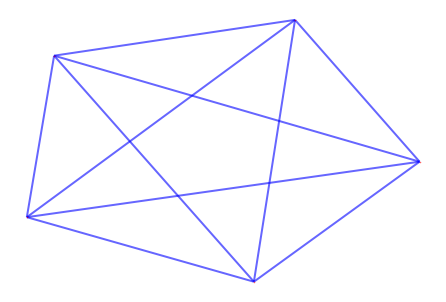

In [ ]:
node = 'xxxxxxxxxx'
G1 = get_n_depth_neighbourhood(G,node, 1)
draw_network(G1, False, highlight_keys=None, weights=True)


This shows a network of personal data for a number of investors sharing a single data point (date of birth), showing the single-weighting of the edges 

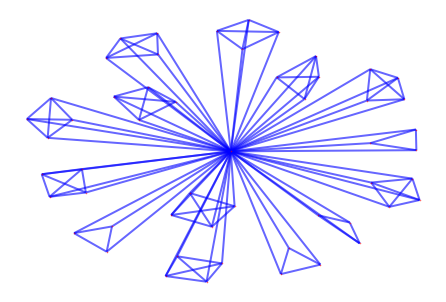

In [ ]:
node =  'xxxxxxxxxx'
G1 = get_n_depth_neighbourhood(G,node, 2)
draw_network(G1, False, highlight_keys=None, weights=True)

This shows a network of 3 investors with some more shared data points - for example sharing a bank account or mobile phone number is possible between a husband and wife, or sharing of an IP address in a corporate setting.

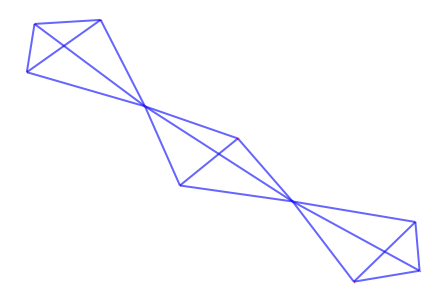

In [ ]:
node =  'xxxxxxxxxx'
G1 = get_n_depth_neighbourhood(G,node, 2)
draw_network(G1, False, highlight_keys=None, weights=True)


### Known Identity Fraud Cases

the images below show the distortions in the network caused by re-use of personal data. **The goal is to identify these re-use cases and any other suspicious data points associated with these data points.**

The reason for this is that in identity theft cases, a fradster may re-use parts of the same identity while varying other parts to test the controls of the system.

the image below shows the first degree connections of two known fraud cases. Immediately you can see the re-used edges (indicated by the weighting of the edge). The highlighting indicates the name.

the first two cases used *some* of the same data points, while varying others

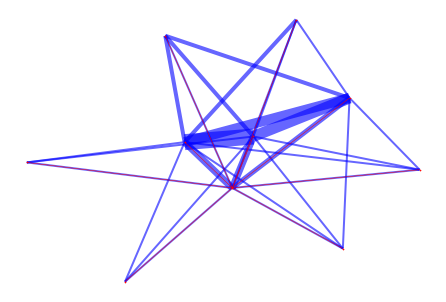

In [ ]:
node = 'will smith'
G1 = get_n_depth_neighbourhood(G,node, 1)
draw_network(G1, False, highlight_keys=['will smith'])

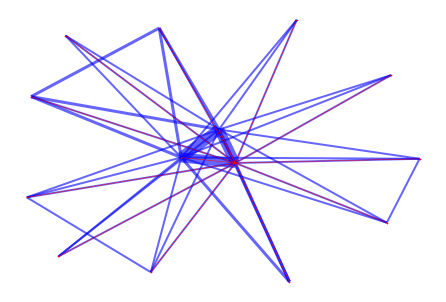

In [ ]:
node =  'xxxxxxxxxx'
G1 = get_n_depth_neighbourhood(G,node, 1)
draw_network(G1, False,[ 'xxxxxxxxxx'])

The image below shows the second degree connections for a known Fraud case. There is a local weight and density surrounding the fraud case, whereas the encircling investors sharing a data point apear normal as per images above. The Fraud case is highlighted in Red

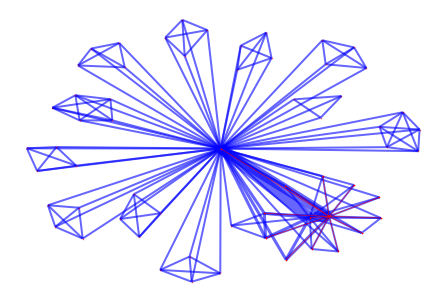

In [ ]:
node =  'xxxxxxxxxx'
G1 = get_n_depth_neighbourhood(G,node, 2)
draw_network(G1, False,[ 'xxxxxxxxxx'])

the following cases used the same data 7 times, without varying the data, explaining the dense weightings of the edges 

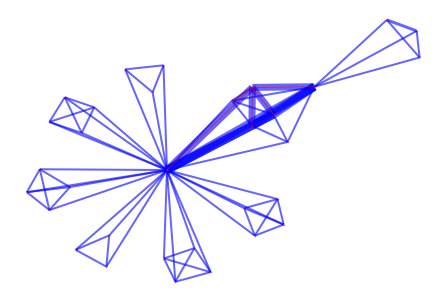

In [ ]:
node =  'xxxxxxxxxx'
G1 = get_n_depth_neighbourhood(G,node, 2)
draw_network(G1, False, highlight_keys=[node])

## Using Network Analysis to detect Identity Reuse Cases

Fraud cases identifiable through the re-use of personal data points are therefore clustered and close to high-weighted edges.

I have tried the following measures in order to find the re-use cases, and the less obvious cases where a fraudster has reused the same data points. 

* clustering coefficient 
* weighted clustering coefficient 
* degree centrality 
* average neighbour degree
* average neighbour edge-weighted degree 
* average neighbour edge-weight 
* average neighbour edge-weight-1
* Eigenvector Centrality 
* Weighted Eigenvector Centrality 
* Weighted Eigenvector Centrality (edge-weight -1)

The results of each of these are outlined in the next section.

The most effective of these were: 

* average neighbour edge-weight-1
* Weighted Eigenvector Centrality (edge-weight-1)




1) **Clustering Coefficient**

Calculates the fraction of completed triangles with a node's neighbours 

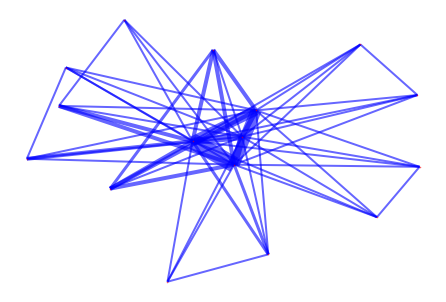

['Node10688:0.04', 'Node52296:0.07', 'Node155368:0.12', 'Node137261:0.06', 'Node47280:0.07', 'Node137458:0.17', 'Node821:0.1', 'Node155393:1.0', 'Node155399:1.0', 'Node155400:0.67', 'Node155405:0.58', 'Node55194:0.18', 'Node155418:0.41', 'Node155419:1.0', 'Node30664:0.12', 'Node57261:0.05']


In [ ]:
# known fraud case
node = 'will smith'
G1 = get_n_depth_neighbourhood(G,node, 1)
cc = nx.clustering(G)
G2 = label_nodes(G1,cc)
draw_network(G2, False, highlight_keys=None)
print(print_scores(G1,cc))

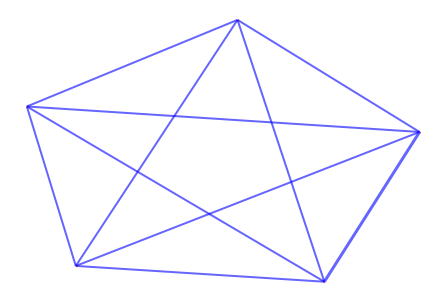

['Node209691:0.57', 'Node209690:0.43', 'Node209693:0.57', 'Node209695:1.0', 'Node209696:1.0']


In [ ]:
# as compared to normal 
node =  'xxxxxxxxxx'
G1 = get_n_depth_neighbourhood(G,node, 1)
cc = nx.clustering(G)
G2 = label_nodes(G1,cc)
draw_network(G2, False, highlight_keys=None)
print(print_scores(G1,cc))

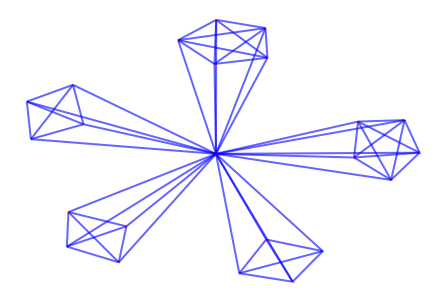

['Node0:0.16', 'Node1:1.0', 'Node2:1.0', 'Node3:1.0', 'Node4:1.0', 'Node56877:1.0', 'Node56878:1.0', 'Node56879:1.0', 'Node56880:1.0', 'Node56881:1.0', 'Node247139:1.0', 'Node247140:1.0', 'Node247141:1.0', 'Node247142:1.0', 'Node247143:0.43', 'Node247144:1.0', 'Node247145:1.0', 'Node71053:0.28', 'Node135189:0.21', 'Node247146:1.0', 'Node247147:1.0', 'Node247148:1.0', 'Node247149:1.0']


In [ ]:
# normal case
node =  'xxxxxxxxxx'
G1 = get_n_depth_neighbourhood(G,node, 2)
cc = nx.clustering(G)
G2 = label_nodes(G1,cc)
draw_network(G2, False, highlight_keys=None)
print(print_scores(G1,cc))



---


**conclusion**: since the clustering coefficient scores 1 often on non-suspicious, self contained investors (as proven by the normal cases above), it is of no use for the network of semi-personal data


---



2) **Degree Centrality**

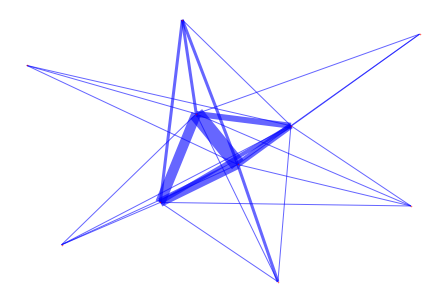

['Node8951:0.0', 'Node43546:0.0', 'Node128530:0.0', 'Node113588:0.0', 'Node39383:0.0', 'Node113751:0.0', 'Node674:0.0', 'Node128562:0.0', 'Node25592:0.0', 'Node47658:0.0']


In [ ]:
# fraud case 
node = 'will smith'
G1 = get_n_depth_neighbourhood(G,node, 1)
cc = nx.degree_centrality(G)
G2 = label_nodes(G1,cc)
draw_network(G2, False, highlight_keys=None)
print(print_scores(G1,cc))

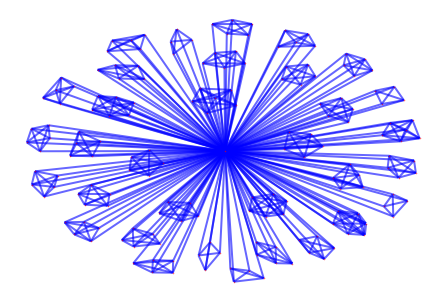

['Node1169:0.0', 'Node1170:0.0', 'Node1171:0.0', 'Node1172:0.0', 'Node1173:0.0', 'Node1174:0.0', 'Node13080:0.0', 'Node13081:0.0', 'Node13082:0.0', 'Node13083:0.0', 'Node13084:0.0', 'Node27470:0.0', 'Node27471:0.0', 'Node27472:0.0', 'Node27473:0.0', 'Node27474:0.0', 'Node27475:0.0', 'Node79902:0.0', 'Node79903:0.0', 'Node79904:0.0', 'Node79905:0.0', 'Node79906:0.0', 'Node87348:0.0', 'Node87349:0.0', 'Node87350:0.0', 'Node87351:0.0', 'Node87352:0.0', 'Node110288:0.0', 'Node110289:0.0', 'Node110290:0.0', 'Node110291:0.0', 'Node110292:0.0', 'Node139462:0.0', 'Node139465:0.0', 'Node139467:0.0', 'Node139468:0.0', 'Node139470:0.0', 'Node173642:0.0', 'Node173643:0.0', 'Node173644:0.0', 'Node173645:0.0', 'Node173646:0.0', 'Node174799:0.0', 'Node174800:0.0', 'Node174801:0.0', 'Node174802:0.0', 'Node174803:0.0', 'Node187419:0.0', 'Node187420:0.0', 'Node187421:0.0', 'Node187422:0.0', 'Node187423:0.0', 'Node187424:0.0', 'Node555125:0.0', 'Node555126:0.0', 'Node555127:0.0', 'Node555128:0.0', 'Node5

In [ ]:
# showing the highest scoring node 
cc = nx.degree_centrality(G)
node = keywithmaxval(cc)
G1 = get_n_depth_neighbourhood(G,node, 1)
G2 = label_nodes(G1,cc)
draw_network(G2, False, highlight_keys=None)
print(print_scores(G1,cc))



---


**conclusion:** since the degree centrality find the most connected node in the network, it is of no use here, as it finds simply the most used semi-personal data point (likely a Date of Birth)


---



3) **Weighted Clustering Coefficient**

Calculates the fraction of completed triangles with a node's neighbours, weighted by the edge-weight/max(edge weight in graph)

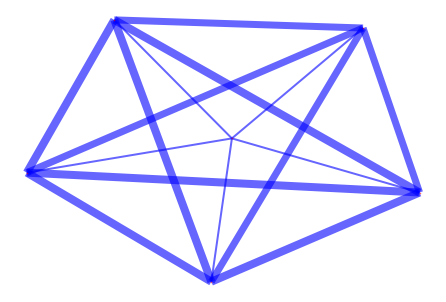

['Node270106:0.1', 'Node111635:0.01', 'Node270109:0.12', 'Node270110:0.24', 'Node270113:0.3', 'Node270122:0.24']


In [ ]:
# fraud case 
node =  'xxxxxxxxxx'
G1 = get_n_depth_neighbourhood(G,node, 1)
cc = nx.clustering(G,weight='count')
G2 = label_nodes(G1,cc)
draw_network(G2, False, highlight_keys=None)
print(print_scores(G1,cc))

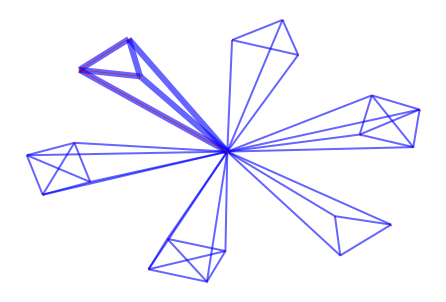

['Node32429:0.01', 'Node32430:0.07', 'Node32431:0.03', 'Node32432:0.07', 'Node32433:0.07', 'Node261671:0.07', 'Node218797:0.03', 'Node261672:0.07', 'Node261673:0.33', 'Node261674:0.07', 'Node261675:0.07', 'Node261676:0.07', 'Node42499:0.02', 'Node261677:0.07', 'Node237119:0.03', 'Node261678:0.33', 'Node261679:0.33', 'Node261680:0.07', 'Node261681:0.07', 'Node261682:0.07', 'Node261683:0.07', 'Node261684:0.07']
44 7795602293


In [ ]:
# showing the highest scoring node 
node = keywithmaxval(cc)
G1 = get_n_depth_neighbourhood(G,node, 2)
draw_network(G1, False, highlight_keys=[node])
print(print_scores(G1,cc))




---


**conclusion:** the weighted clustering co-efficient has scored normal cases highly and does not sufficiently draw out the edge weights (or the edge weight equalling 1 is too heavily weighted in the algorithm)


---



4. **Average Neighbour Degree**

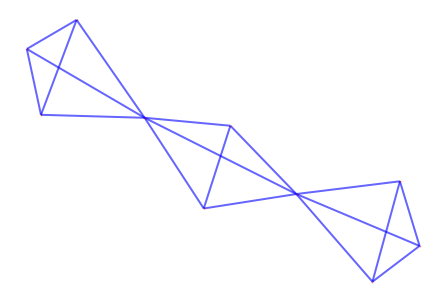

['Node169025:3.5', 'Node173267:4.0', 'Node173268:4.5', 'Node173269:5.0', 'Node173270:5.0', 'Node173271:5.0', 'Node173272:5.0', 'Node181869:3.33', 'Node181874:6.0', 'Node181876:6.0']


In [ ]:
# normal case 
node =  'xxxxxxxxxx'
G1 = get_n_depth_neighbourhood(G,node, 2)
cc = nx.average_neighbor_degree(G)
draw_network(G1, False, highlight_keys=None)
print(print_scores(G1,cc))

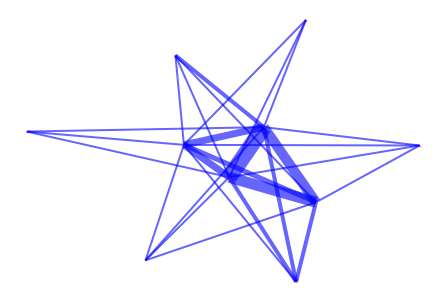

['Node8951:6.14', 'Node43546:22.72', 'Node128530:8.96', 'Node113588:7.04', 'Node39383:7.38', 'Node113751:33.52', 'Node674:27.62', 'Node128562:46.67', 'Node25592:6.86', 'Node47658:4.96']


In [ ]:
# fraud case
node = 'will smith'
G1 = get_n_depth_neighbourhood(G,node, 1)
draw_network(G1, False, highlight_keys=None)
print(print_scores(G1,cc))

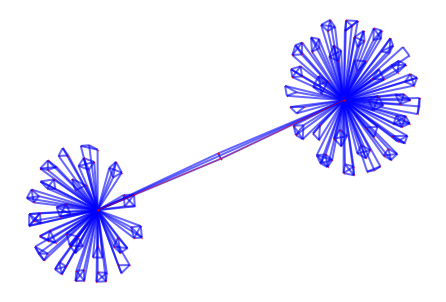

['Node17192:6.55', 'Node17193:48.25', 'Node17194:48.25', 'Node17195:17.08', 'Node17196:48.25', 'Node49222:5.81', 'Node49223:24.0', 'Node49224:24.0', 'Node49225:24.0', 'Node49226:24.0', 'Node57004:24.0', 'Node57005:24.0', 'Node57006:24.0', 'Node57007:24.0', 'Node30384:5.94', 'Node72521:44.75', 'Node72522:44.75', 'Node72523:44.75', 'Node12117:5.76', 'Node77778:50.5', 'Node77779:50.5', 'Node77780:50.5', 'Node124166:22.4', 'Node124167:22.4', 'Node124168:22.4', 'Node124169:19.69', 'Node124170:22.4', 'Node113140:6.37', 'Node135801:45.25', 'Node135802:45.25', 'Node135803:45.25', 'Node14327:5.88', 'Node142776:53.75', 'Node142777:53.75', 'Node142778:53.75', 'Node25587:6.86', 'Node162135:41.0', 'Node162136:41.0', 'Node162137:41.0', 'Node178315:60.5', 'Node178316:60.5', 'Node276670:56.33', 'Node5560:7.23', 'Node276685:56.33', 'Node294820:36.5', 'Node111918:9.89', 'Node294821:36.5', 'Node294830:36.5', 'Node296682:39.5', 'Node76181:7.68', 'Node296687:39.5', 'Node296693:39.5', 'Node311440:49.67', 'N

In [ ]:
# showing the highest scoring node 
node = keywithmaxval(cc)
G1 = get_n_depth_neighbourhood(G,node, 2)
draw_network(G1, False, highlight_keys=[node])
print(print_scores(G1,cc))



---


**conclusion:** the average neighbour degree finds simply the data point neighbouring the two most used semi-personal data points (a common Date of Birth, and a common name or similar). Therefore this is of little use


---



5. **Average Neighbour Degree (Weighted)**

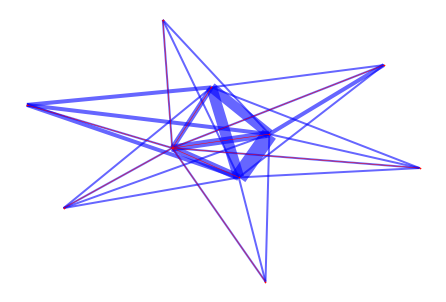

       score
Node9  44.73
Node7  37.84
Node0  28.94
Node4  27.94
Node3  11.83
Node8   8.96
Node6   8.73
Node2   6.86
Node1   6.14
Node5   4.96


In [ ]:
# Fraud Case
node = 'will smith'
G1 = get_n_depth_neighbourhood(G,node, 1)
cc = nx.average_neighbor_degree(G,weight='count')
draw_network(G1, False, highlight_keys=[node])
print(print_scores(G1,cc))

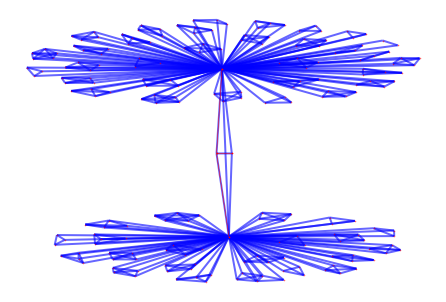

         score
Node131  68.67
Node157  68.67
Node179  66.67
Node180  66.67
Node181  65.00
...        ...
Node6     5.76
Node18    5.75
Node40    5.64
Node41    5.61
Node5     5.55

[201 rows x 1 columns]
44 7963001983


In [ ]:
# showing the highest scoring node 
node = keywithmaxval(cc)
G1 = get_n_depth_neighbourhood(G,node, 2)
draw_network(G1, False, highlight_keys=[node])
print(print_scores(G1,cc))
print(node)



---


**conclusion:** 

This is much more successfully at identifying dummy, fraud and test data, and the nodes associated with that data.

However, the weighted neighbour degree (and therefore the average degree) is highly influenced by high degree, single weighted edges. It therefore identifies normal cases connected through a neighbour to high degree data points. 


---



6. **Average Neighbour Edge Weight**

Takes the average weight of the neighbour edges, as well (alternatively) the average of the average of the neighbour weights

In [ ]:
# set up the functions, these are adapted from the open source networkx functions
# takes the average weight of the neighbouring nodes  
def average_neighbour_weights(G, weight='weight'):
  avg = {}
  source_degree = G.degree
  # get each node
  for n, deg in source_degree():
    total_weight = 0
    nbrdeg = source_degree(G[n])
    for neighbor, n_deg in nbrdeg:
      total_weight = total_weight + sum(G[neighbor][g][weight] for g in dict(G[neighbor]))
    avg[n] = total_weight/deg
  return avg

# takes the average of the average weight of the neighbouring nodes  
def average_average_neighbour_weights(G, weight='weight'):
  avg = {}
  source_degree = G.degree
  # get each node
  for n, deg in source_degree():
    sum_avgs = 0
    nbrdeg = source_degree(G[n])
    for neighbor, n_deg in nbrdeg:
      sum_avgs = sum_avgs + sum(G[neighbor][g][weight] for g in dict(G[neighbor]))/n_deg 
    avg[n] = sum_avgs/deg
  return avg


In [ ]:
cc = average_neighbour_weights(G,'count')

In [ ]:
node = 'will smith'
G1 = get_n_degree_neighbourhood(G,node, 1)
print(print_scores(G1,cc))

       score
Node9  62.22
Node7  38.85
Node0  31.27
Node4  25.50
Node8  14.30
Node3  10.55
Node2  10.54
Node6  10.15
Node1   8.14
Node5   6.91


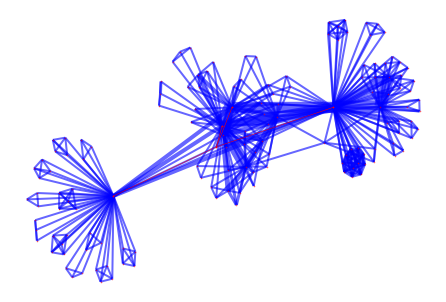

        score
Node86  81.00
Node77  80.25
Node72  78.25
Node74  75.00
Node78  73.25
...       ...
Node25   6.31
Node6    6.29
Node15   6.24
Node54   6.22
Node22   5.64

[143 rows x 1 columns]
test tester


In [ ]:
# showing the highest scoring node 
node = keywithmaxval(cc)
G1 = get_n_depth_neighbourhood(G,node, 2)
draw_network(G1, False, highlight_keys=[node])
print(print_scores(G1,cc))
print(node)


In [ ]:
# showing the highest scoring nodes 
df = pd.DataFrame.from_dict(cc.items())
df.sort_values(by=1,inplace=True, ascending=False)
df.head(8)

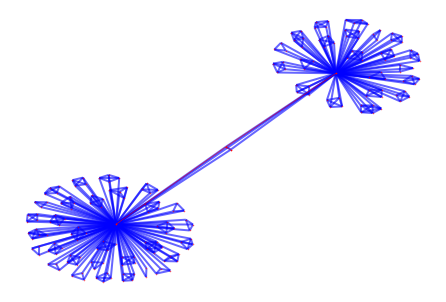

         score
Node131  69.33
Node157  69.33
Node179  66.67
Node180  66.67
Node181  65.00
...        ...
Node20    5.86
Node19    5.77
Node6     5.77
Node40    5.64
Node5     5.55

[201 rows x 1 columns]


In [ ]:
# however, it still finds nodes associated with high degree, single weighted subnetworks:
node =  'xxxxxxxxxx'
G1 = get_n_depth_neighbourhood(G,node, 2)
draw_network(G1, False, highlight_keys=[node])
print(print_scores(G1,cc))

7. **Average Neighbour Edge Weight (discounting single-weight edges)**

In [ ]:
cc = average_neighbour_weights(G,'count_minus_1')

In [ ]:
# known fraud case 
node = 'will smith'
G1 = get_n_degree_neighbourhood(G,node, 1)
print(print_scores(G1,cc))

       score
Node9  15.56
Node7   5.33
Node8   5.33
Node2   3.68
Node0   3.64
Node3   3.17
Node6   3.11
Node4   2.78
Node1   2.00
Node5   1.94


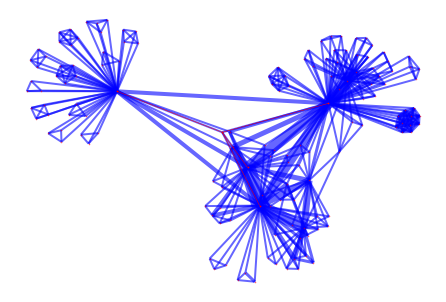

         score
Node86   34.25
Node72   32.75
Node90   27.40
Node51   26.75
Node111  26.00
...        ...
Node46    0.86
Node22    0.85
Node15    0.80
Node31    0.71
Node102   0.52

[143 rows x 1 columns]
test tester


In [ ]:
# showing the highest scoring node 
node = keywithmaxval(cc)
G1 = get_n_depth_neighbourhood(G,node, 2)
draw_network(G1, False, highlight_keys=[node])
print(print_scores(G1,cc))
print(node)

In [ ]:
# showing the highest scoring nodes 
df = pd.DataFrame.from_dict(cc.items())
df.sort_values(by=1,inplace=True, ascending=False)
df.head(5)

,0,1
128557,test tester,34.25
128543,cxz vcb,32.75
128561,will smith,27.40
113750,11234562,26.75
545846,test TEST,26.00


---


**conclusion:** 

This is much more successfully at identifying dummy, fraud and test data, and the nodes associated with that data, even if there is a low-weight connection with that data, since it is connected to high-reuse data

by ignoring single-weighted edges in the calculation of the score (by setting weight=1 to weight =0), the score weights highly reused data, and then surfaces data points associated with that data, ignoring high-degree semi-personal data where there is no reuse. 

The known Fraud case was identified 3rd (1.3 million edge network) with 2 other cases in the top 20. The remainder was reused test or dummy data. 


---


8. **Eignevector Centrality**

In [ ]:
cc = nx.eigenvector_centrality(G)

In [ ]:
# known fraud case 
node = 'will smith'
G1 = get_n_degree_neighbourhood(G,node, 1)
print(print_scores(G1,cc))

       score
Node9  44.73
Node7  37.84
Node0  28.94
Node4  27.94
Node3  11.83
Node8   8.96
Node6   8.73
Node2   6.86
Node1   6.14
Node5   4.96


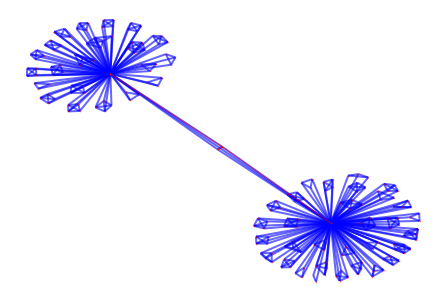

         score
Node131  68.67
Node157  68.67
Node179  66.67
Node180  66.67
Node181  65.00
...        ...
Node6     5.76
Node18    5.75
Node40    5.64
Node41    5.61
Node5     5.55

[201 rows x 1 columns]
44 7963001983


In [ ]:
# showing the highest scoring node 
node = keywithmaxval(cc)
G1 = get_n_depth_neighbourhood(G,node, 2)
draw_network(G1, False, highlight_keys=[node])
print(print_scores(G1,cc))

---


**conclusion:** 

Standard, non-wieghted Eigenvector centrality has idenitfied nodes connected to high-degree nodes, thereby identifying non-suspicious data


---


9. **Weighted Eignevector Centrality**

In [ ]:
cc = nx.eigenvector_centrality(G, weight='count')

In [ ]:
# known fraud case 
node = 'will smith'
G1 = get_n_degree_neighbourhood(G,node, 1)
print(print_scores(G1,cc))

       score
Node0   0.51
Node4   0.45
Node7   0.44
Node9   0.22
Node3   0.13
Node6   0.09
Node1   0.05
Node8   0.05
Node2   0.03
Node5   0.03


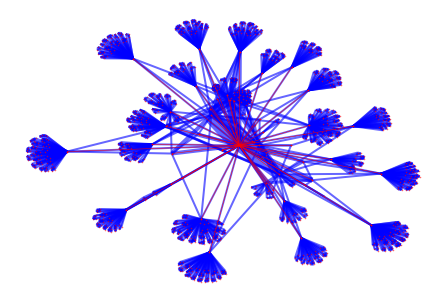

          score
Node5      0.51
Node94     0.45
Node195    0.44
Node236    0.24
Node4      0.22
...         ...
Node414    0.00
Node415    0.00
Node416    0.00
Node417    0.00
Node1040   0.00

[1041 rows x 1 columns]


In [ ]:
# showing the highest scoring node 
node = keywithmaxval(cc)
G1 = get_n_depth_neighbourhood(G,node, 2)
draw_network(G1, False, highlight_keys=[node])
print(print_scores(G1,cc))

In [ ]:
# showing the highest scoring nodes 
df = pd.DataFrame.from_dict(cc.items())
df.sort_values(by=1,inplace=True, ascending=False)
df.head(5)

---


**conclusion:** 

Weighted Eigenvector centrality has idenitfied suspicious nodes successfully, with 2 known fraud cases being listed in the top 20 (1.3 million edge network)


---

7. **Weighted Eignevector Centrality (discounting single-weight edges)**

In [ ]:
cc = nx.eigenvector_centrality(G, weight='count_minus_1')

In [ ]:
# known fraud case 
node = 'will smith'
G1 = get_n_degree_neighbourhood(G,node, 1)
print(print_scores(G1,cc))

       score
Node0   0.54
Node7   0.47
Node4   0.46
Node9   0.22
Node3   0.10
Node6   0.04
Node1   0.00
Node2   0.00
Node5   0.00
Node8   0.00


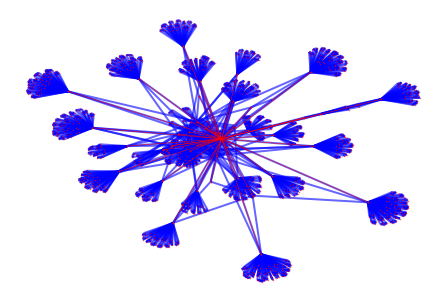

          score
Node5      0.54
Node195    0.47
Node94     0.46
Node236    0.24
Node4      0.23
...         ...
Node361    0.00
Node362    0.00
Node363    0.00
Node364    0.00
Node1040   0.00

[1041 rows x 1 columns]


In [ ]:
# showing the highest scoring node 
node = keywithmaxval(cc)
G1 = get_n_depth_neighbourhood(G,node, 2)
draw_network(G1, False, highlight_keys=[node])
print(print_scores(G1,cc))

In [ ]:
# showing the highest scoring nodes 
df = pd.DataFrame.from_dict(cc.items())
df.sort_values(by=1,inplace=True, ascending=False)
df.head(5)

,0,1
674,AB123456B,0.537272
113751,44 7911234567,0.473194
43546,12345678,0.460672
128532,44 7123456789,0.237193
673,44 7911123456,0.229754


---


**conclusion:** 

Weighted Eigenvector centrality using (edge weight -1) has idenitfied suspicious nodes successfully, with the known 4 fraud cases being listed in the top 20 (1.3 million edge network) 


---